# Ejercicio de clase Clasificación de sexo 

## Sistemas de Percepción

#### Autor: Doramas Báez Bernal

### Introducción 

La tarea consiste en generar una tabla haciendo uso de varios esquemas de representación y/ o clasificadores (al menos 3 variantes) con tasas de acierto de reconocimiento de sexo haciendo uso de la base de datos DB SIANI 59x65 Grande. 

En este caso, se han utilizado para las pruebas los clasificadores 
"KNeighborsClassifier" y "RandomForestClassifier". Por otra parte, se han utilizado como técnicas de reducción de dimensionalidad el "PCA" y el "LocallyLinearEmbedding" (LLE).


In [92]:
import os
import numpy as np
import cv2

from matplotlib import pyplot as plt
import matplotlib 

from time import time
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score
from sklearn.decomposition import PCA
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Carga conjunto de datos

Para cargar el conjunto de datos, nos hemos basado en los ejemplos proporcionados en la asignatura. En este caso, se trabajará con el conjunto de datos "DatabaseGender59x65", esta carpeta está conformada por unas subcarpetas que se corresponden con cada clase. Cada clase contiene muestras en forma de imágenes jpg, todas del mismo tamaño.


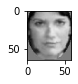

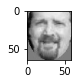

Dataset info:
# samples: 1184
# featues: 3835
# classes: 2
classes ['Female', 'Male']
samples per class 582, 602


In [93]:
folder = "./DatabaseGender59x65"
# Contador de número de clases del conjunto
nclasses = 0
# Contador de muestras por clase
nperclass = []
# Etiqueta de cada clase (nombre de la subcarpeta)
classlabels = []
# Inicializa estructuras de datos y sus correpondientes etiquetas
X = []
Y = []

# Valor de resolución por defecto de matplotlib
dpi = matplotlib.rcParams['figure.dpi']

# Asume que en la ruta indicada hay una subcarpeta por clase
for class_name in os.listdir(folder):
    # Cada subcarpeta implica una clase más
    nclasses += 1
    # Inicialmente esta clase no tiene muestras
    nsamples = 0

    # Compone la ruta
    class_folder = os.path.join(folder, class_name)
    for file_name in os.listdir(class_folder):
        # Asume imágenes en formato jpg
        if file_name.endswith('.jpg'):
            # Lee la imagen
            image = cv2.imread (os.path.join(class_folder, file_name),)
            
            # Lugar para aplicar un RoI
            
            # Extrae tamaños
            height, width, depth = image.shape
            # Convierte  grises
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            # Añade a X, previa conversión en vector
            X.append(gray.reshape(height*width))
            # Añade etiqueta numérica de la muestra
            Y.append(nclasses-1)
            # Muestra primera imagen de la clase
            if nsamples == 0:
                figsize = width / float(dpi), height / float(dpi)

                plt.figure(figsize=figsize)
                plt.imshow(gray, cmap='gray', vmin=0, vmax=255)
                plt.show()
  
            #Incrementa el número de muestras
            nsamples += 1
    nperclass.append(nsamples)
    classlabels.append(class_name)
    
#Convierte a numpy array X e Y
X = np.array(X,dtype='float32')
Y = np.array(Y,dtype='float64')

# Muestra datos del conjunto leído
# Depuración
#print(X.shape)
#print(Y.shape)
# Obtiene número de muestras y características
n_samples , n_features = X.shape
# Obtiene nombres de las clases
class_names = np.array(classlabels)
n_classes = class_names.shape[0]

print("Dataset info:")
print("# samples: %d" % n_samples)
print("# featues: %d" % n_features)
print("# classes: %d" % n_classes)
print("classes %s" % classlabels)
print("samples per class %s" % str(nperclass)[1:-1] )


# Diseña conjunto experimental k-fold

Para tener un muestreo más fiable se realizará un k-fold con valor 5

In [94]:
# StratifiedKFold
skf = StratifiedKFold(n_splits=5, random_state=4, shuffle=True)

fold = 1
for train_index, test_index in skf.split(X, Y):
    #print("TRAIN:", train_index, "TEST:", test_index)
    print("Fold %d" % fold)
    print("# samples in training set %d" % train_index.shape[0])
    print("# samples in test set %d" % test_index.shape[0])
    fold += 1

Fold 1
# samples in training set 947
# samples in test set 237
Fold 2
# samples in training set 947
# samples in test set 237
Fold 3
# samples in training set 947
# samples in test set 237
Fold 4
# samples in training set 947
# samples in test set 237
Fold 5
# samples in training set 948
# samples in test set 236


## PCA 90% + KNN para 8

La primera prueba que se realizará consistirá en realizar un PCA con un 90% de varianza para luego aplicar el "KNeighborsClassifier" para los 8 vecinos más proximos. Se realizará un split del conjunto de datos para disponer de un conjunto de entrenamiento y un conjunto de test que se utilizará para obtener las metricas.

In [95]:
print("PCA 90% + KNN 8")
k = 8
precs_pca_knn, recs_pca_knn = [], []

fold = 1
for train_index, test_index in skf.split(X, Y):
    #print("TRAIN:", train_index, "TEST:", test_index)
    print("***\nFold %d" % fold)

    # Separamos el conjuto de datos en entrenamiento y en test
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    
    # Se realiza el análisis de componentes principales para un 90% de varianza
    print("PCA computation for .90 of the variance from %d faces..."
      % (X_train.shape[0]))
    t0 = time()
    pca = PCA(.90).fit(X_train)
    print("done in %0.3fs" % (time() - t0))
    print("%d components selected" % (pca.n_components_ ))

    eigenfaces = pca.components_.reshape((pca.n_components_ , height, width))

    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)

    # Utilizar los resusltados del pca para el entrenamiento del KNN
    print("KNN (k=%d) classifier based on %d PCA components..." % (k, pca.n_components_) ) 
    t0 = time()
    model_pca = KNeighborsClassifier(n_neighbors = k) 

    model_pca.fit(X_train_pca, y_train) 
    print("done in %0.3fs" % (time() - t0))

    print("Predicting...")
    t0 = time()
    y_pred=model_pca.predict(X_test_pca)

    print("done in %0.3fs" % (time() - t0))

    print("\nMetrics")
    print(classification_report(y_test, y_pred, target_names=class_names))
    precs_pca_knn.append(precision_score(y_test, y_pred))
    recs_pca_knn.append(recall_score(y_test, y_pred))

    fold += 1


print("\n********Resultados obtenidos*********")
print("KNeighbors Classifier + PCA Mean Precision:  %0.3f, Mean Recall:  %0.3f" % ( np.mean(precs_pca_knn) , np.mean(recs_pca_knn) ))


PCA 90% + KNN 8
***
Fold 1
PCA computation for .90 of the variance from 947 faces...
done in 1.346s
73 components selected
KNN (k=8) classifier based on 73 PCA components...
done in 0.010s
Predicting...
done in 0.048s

Metrics
              precision    recall  f1-score   support

      Female       0.69      0.74      0.71       117
        Male       0.72      0.68      0.70       120

    accuracy                           0.70       237
   macro avg       0.71      0.71      0.70       237
weighted avg       0.71      0.70      0.70       237

***
Fold 2
PCA computation for .90 of the variance from 947 faces...
done in 1.268s
71 components selected
KNN (k=8) classifier based on 71 PCA components...
done in 0.011s
Predicting...
done in 0.047s

Metrics
              precision    recall  f1-score   support

      Female       0.73      0.84      0.78       117
        Male       0.81      0.69      0.75       120

    accuracy                           0.76       237
   macro avg     

## Random Forest

En este apartado se probará el clasificador "Random Forest", este clasificador es bastante utilizado ya que para un conjunto de datos los suficientemente grande suele producir unos resultados bastante óptimos. En este caso, no aplicaremos reducción de la dimensionalidad de los datos para posteriormente compararlo con el mismo clasificador pero aplicando dicha técnica.

In [96]:
print("Random Forest")

precs_rf, recs_rf = [], []

fold = 1
for train_index, test_index in skf.split(X, Y):
    #print("TRAIN:", train_index, "TEST:", test_index)
    print("***\nFold %d" % fold)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]

    t0 = time()
    print("Fit Random Forest classifier")
    model_forest = RandomForestClassifier()

    model_forest.fit(X_train, y_train) 
    print("done in %0.3fs" % (time() - t0))

    print("================================================")
    print("Predicting...")
    t0 = time()
    y_pred=model_forest.predict(X_test)
    print("done in %0.3fs" % (time() - t0))

    print("\nMetrics")
    print(classification_report(y_test, y_pred, target_names=class_names))
    precs_rf.append(precision_score(y_test, y_pred))
    recs_rf.append(recall_score(y_test, y_pred))

    fold += 1


print("\n********Resultados obtenidos*********")
print("Random Forest Classifier Mean Precision:  %0.3f, Mean Recall:  %0.3f" % ( np.mean(precs_rf) , np.mean(recs_rf) ))

Random Forest
***
Fold 1
Fit Random Forest classifier
done in 2.165s
Predicting...
done in 0.015s

Metrics
              precision    recall  f1-score   support

      Female       0.80      0.76      0.78       117
        Male       0.78      0.82      0.80       120

    accuracy                           0.79       237
   macro avg       0.79      0.79      0.79       237
weighted avg       0.79      0.79      0.79       237

***
Fold 2
Fit Random Forest classifier
done in 2.222s
Predicting...
done in 0.015s

Metrics
              precision    recall  f1-score   support

      Female       0.75      0.77      0.76       117
        Male       0.77      0.75      0.76       120

    accuracy                           0.76       237
   macro avg       0.76      0.76      0.76       237
weighted avg       0.76      0.76      0.76       237

***
Fold 3
Fit Random Forest classifier
done in 2.086s
Predicting...
done in 0.014s

Metrics
              precision    recall  f1-score   support

## PCA 90% + Random Forest

Ahora se comparará los resultados del "Random Forest" con los resultados obtenidos en este apartado, donde para el mismo clasificador aplicaremos una técnica de reducción de dimensionalidad, en concreto el "PCA".

In [97]:
print("PCA 90% + Random Forest")

precs_pca_rf, recs_pca_rf = [], []

fold = 1
for train_index, test_index in skf.split(X, Y):
    #print("TRAIN:", train_index, "TEST:", test_index)
    print("***\nFold %d" % fold)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    

    print("PCA computation for .90 of the variance from %d faces..."
      % (X_train.shape[0]))
    t0 = time()
    pca = PCA(.90).fit(X_train)
    print("done in %0.3fs" % (time() - t0))
    print("%d components selected" % (pca.n_components_ ))

    eigenfaces = pca.components_.reshape((pca.n_components_ , height, width))

    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)

    print("Random Forest classifier based on %d PCA components..." % (pca.n_components_) ) 
    t0 = time()

    model_forest = RandomForestClassifier()

    model_forest.fit(X_train_pca, y_train) 
    print("done in %0.3fs" % (time() - t0))

    print("================================================")
    print("Predicting...")
    t0 = time()
    y_pred=model_forest.predict(X_test_pca)

    print("done in %0.3fs" % (time() - t0))

    print("\nMetrics")
    print(classification_report(y_test, y_pred, target_names=class_names))
    precs_pca_rf.append(precision_score(y_test, y_pred))
    recs_pca_rf.append(recall_score(y_test, y_pred))

    fold += 1


print("\n********Resultados obtenidos*********")
print("Random Forest Classifier + PCA  Mean Precision:  %0.3f, Mean Recall:  %0.3f" % ( np.mean(precs_pca_rf) , np.mean(recs_pca_rf) ))

PCA 90% + Random Forest
***
Fold 1
PCA computation for .90 of the variance from 947 faces...
done in 1.299s
73 components selected
Random Forest classifier based on 73 PCA components...
done in 0.475s
Predicting...
done in 0.012s

Metrics
              precision    recall  f1-score   support

      Female       0.84      0.79      0.81       117
        Male       0.80      0.86      0.83       120

    accuracy                           0.82       237
   macro avg       0.82      0.82      0.82       237
weighted avg       0.82      0.82      0.82       237

***
Fold 2
PCA computation for .90 of the variance from 947 faces...
done in 1.283s
71 components selected
Random Forest classifier based on 71 PCA components...
done in 0.492s
Predicting...
done in 0.012s

Metrics
              precision    recall  f1-score   support

      Female       0.82      0.88      0.85       117
        Male       0.88      0.82      0.84       120

    accuracy                           0.85       237
 

## LocallyLinearEmbedding + KNN para 8

En este caso, se aplicará una técnica distinta de reducción de dimensionalidad. A diferencia del PCA que está pensado para datos lineales, el LLE se aplica para datos no lineales. El interés de esta prueba, consiste en ver como se comportan los mismos clasificadores para un esquema de representancion diferente.

In [101]:
print("LocallyLinearEmbedding + KNN 8")

precs_lle_knn, recs_lle_knn = [], []

k = 8
fold = 1
for train_index, test_index in skf.split(X, Y):
    #print("TRAIN:", train_index, "TEST:", test_index)
    print("***\nFold %d" % fold)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    
    print("LocallyLinearEmbedding computation") 
    t0 = time()
    
    embedding = LocallyLinearEmbedding(n_components=2).fit(X_train)

    print("done in %0.3fs" % (time() - t0))

    X_train_lle = embedding.transform(X_train)
    X_test_lle = embedding.transform(X_test)

    print("Fit KNN (k=%d) " % (k))
    t0 = time()
        
    model_lle = KNeighborsClassifier(n_neighbors = k) 

    # fdtraining of model 
    model_lle.fit(X_train_lle, y_train) 
    print("done in %0.3fs" % (time() - t0))

    print("Predicting...")
    t0 = time()
    y_pred=model_lle.predict(X_test_lle)

    print("done in %0.3fs" % (time() - t0))

    print("\nMetrics")
    print(classification_report(y_test, y_pred, target_names=class_names))
    precs_lle_knn.append(precision_score(y_test, y_pred))
    recs_lle_knn.append(recall_score(y_test, y_pred))

    fold += 1


print("\n********Resultados obtenidos*********")
print("KNeighbors  Classifier + LLE Mean Precision:  %0.3f, Mean Recall:  %0.3f" % ( np.mean(precs_lle_knn) , np.mean(recs_lle_knn) ))

LocallyLinearEmbedding + KNN 8
***
Fold 1
LocallyLinearEmbedding computation
done in 5.891s
Fit KNN (k=8) 
done in 0.001s
Predicting...
done in 0.007s

Metrics
              precision    recall  f1-score   support

      Female       0.58      0.69      0.63       117
        Male       0.63      0.51      0.56       120

    accuracy                           0.60       237
   macro avg       0.60      0.60      0.60       237
weighted avg       0.60      0.60      0.60       237

***
Fold 2
LocallyLinearEmbedding computation
done in 6.096s
Fit KNN (k=8) 
done in 0.001s
Predicting...
done in 0.008s

Metrics
              precision    recall  f1-score   support

      Female       0.58      0.65      0.61       117
        Male       0.61      0.53      0.57       120

    accuracy                           0.59       237
   macro avg       0.59      0.59      0.59       237
weighted avg       0.59      0.59      0.59       237

***
Fold 3
LocallyLinearEmbedding computation
done in 5.8

## LocallyLinearEmbedding + Random Forest

Como en el apartado anterior se quiere estudiar el comportamiento del "Random forest" utlizando como esquema de representacion el LLE.

In [99]:
print("LocallyLinearEmbedding + Random Forest")

precs_lle_rf, recs_lle_rf = [], []

fold = 1
for train_index, test_index in skf.split(X, Y):
    #print("TRAIN:", train_index, "TEST:", test_index)
    print("***\nFold %d" % fold)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    
    print("LocallyLinearEmbedding computation")
    t0 = time()
    embedding = LocallyLinearEmbedding(n_components=2).fit(X_train)

    print("done in %0.3fs" % (time() - t0))
    print("%d components selected" % (pca.n_components_ ))


    X_train_lle = embedding.transform(X_train)
    X_test_lle = embedding.transform(X_test)

    print("Fit Random Forest classifier")
    t0 = time()

    model_forest = RandomForestClassifier()

    model_forest.fit(X_train_lle, y_train) 
    print("done in %0.3fs" % (time() - t0))

    print("================================================")
    print("Predicting...")
    t0 = time()
    y_pred=model_forest.predict(X_test_lle)

    print("done in %0.3fs" % (time() - t0))

    print("\nMetrics")
    print(classification_report(y_test, y_pred, target_names=class_names))
    precs_lle_rf.append(precision_score(y_test, y_pred))
    recs_lle_rf.append(recall_score(y_test, y_pred))

    fold += 1


print("\n********Resultados obtenidos*********")
print("Random Forest Classifier + LLE Mean Precision:  %0.3f, Mean Recall:  %0.3f" % ( np.mean(precs_lle_rf) , np.mean(recs_lle_rf) ))

LocallyLinearEmbedding + Random Forest
***
Fold 1
LocallyLinearEmbedding computation
done in 5.521s
70 components selected
Fit Random Forest classifier
done in 0.186s
Predicting...
done in 0.015s

Metrics
              precision    recall  f1-score   support

      Female       0.57      0.59      0.58       117
        Male       0.59      0.57      0.58       120

    accuracy                           0.58       237
   macro avg       0.58      0.58      0.58       237
weighted avg       0.58      0.58      0.58       237

***
Fold 2
LocallyLinearEmbedding computation
done in 5.418s
70 components selected
Fit Random Forest classifier
done in 0.195s
Predicting...
done in 0.014s

Metrics
              precision    recall  f1-score   support

      Female       0.60      0.58      0.59       117
        Male       0.60      0.62      0.61       120

    accuracy                           0.60       237
   macro avg       0.60      0.60      0.60       237
weighted avg       0.60      0

## Resultados

### Resultados obtenidos


In [102]:
print("\n********Resultados obtenidos*********")

print("KNeighbors Classifier + PCA Mean Precision:  %0.3f, Mean Recall:  %0.3f" % ( np.mean(precs_pca_knn) , np.mean(recs_pca_knn) ))
print("Random Forest Classifier Mean Precision:  %0.3f, Mean Recall:  %0.3f" % ( np.mean(precs_rf) , np.mean(recs_rf) ))
print("Random Forest Classifier + PCA Mean Precision:  %0.3f, Mean Recall:  %0.3f" % ( np.mean(precs_pca_rf) , np.mean(recs_pca_rf) ))
print("KNeighbors Classifier + LLE Mean Precision:  %0.3f, Mean Recall:  %0.3f" % ( np.mean(precs_lle_knn) , np.mean(recs_lle_knn) ))
print("Random Forest Classifier + LLE Mean Precision:  %0.3f, Mean Recall:  %0.3f" % ( np.mean(precs_lle_rf) , np.mean(recs_lle_rf) ))


********Resultados obtenidos*********
KNeighbors Classifier + PCA Mean Precision:  0.745, Mean Recall:  0.674
Random Forest Classifier Mean Precision:  0.792, Mean Recall:  0.812
Random Forest Classifier + PCA Mean Precision:  0.833, Mean Recall:  0.854
KNeighbors Classifier + LLE Mean Precision:  0.582, Mean Recall:  0.505
Random Forest Classifier + LLE Mean Precision:  0.579, Mean Recall:  0.595


|  Classifier  	| Preprocessing 	| Mean Precision 	| Mean Recall 	|
|:------------:	|:-------------:	|:--------------:	|:-----------:	|
|  KNeighbors  	|    PCA 90%    	|     74.50%     	|    67.40%   	|
| RandomForest 	|               	|     79.20%     	|    81.20%   	|
| RandomForest 	|    PCA 90%    	|     83.30%     	|    85.40%   	|
|  KNeighbors  	|      LLE      	|     58.20%     	|    50.50%   	|
| RandomForest 	|      LLE      	|     57.90%     	|    59.50%   	|

## Conclusiones

1. Los mejores resultados se obtienen utilizando como clasificador el RandomForest y como esquema de representación el PCA (83.30% precisión). Además, se puede apreciar que incluso sin aplicar el PCA el propio RandomForest obtiene buenos resultados (79.20%).

2. Se consigue obtener unos resultados aceptables para el KNeighbors. Sin embargo, el tiempo de computo es similar al del RandomForest, por lo tanto, es más interesante utilizar RandomForest. 

3. Como se quería comprobar si utilizamos un esquema de representación poco óptimo para los datos, en este caso se está utilizando LocallyLinearEmbedding, se obtiene unos malos resultados. Esto puede ser debido a que, cuando se realiza la reducción de dimensionalidad al estar pensado dicho algoritmo para datos no lineales, los componentes seleccionados son ineficientes.

En general, podemos comentar que es importante conocer las distintas técnicas de esquemas de representación y ser capaz de identificar cual de todas esas técnicas es más óptima para la problematica que estamos tratando. De esta manera, poder intentar optimizar los resultados obtenidos.
